In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from itertools import product

gb_dataset = pd.read_csv("encoded_data.csv")

gb_dataset = gb_dataset[gb_dataset['Price'] > 0]

#Box-Cox transformation to price
gb_dataset['Price'], lambda_ = boxcox(gb_dataset['Price'] + 1)
print(f"Box-Cox Lambda Used: {lambda_}")

gb_dataset['log_Price'] = np.log1p(gb_dataset['Price'])

#Log transformations for skewed features
gb_dataset['log_Kilometers_Driven'] = np.log1p(gb_dataset['Kilometers_Driven'])
gb_dataset['log_Engine'] = np.log1p(gb_dataset['Engine'].replace(0, 1))
gb_dataset['log_Power'] = np.log1p(gb_dataset['Power'].replace(0, 1))


#Feature Engineering:Car Age
gb_dataset['Car_Age'] = 2025 - gb_dataset['model_year']
gb_dataset.drop(columns=['model_year'], inplace=True)

gb_dataset = gb_dataset[gb_dataset['Engine'] > 100]

#WE HAVE A PROBLEM WITH THE LUXURY CARS IT DOESNT WORK OR SMTH IS WRONG KISACA
gb_dataset['Luxury'] = (gb_dataset['Price'] > 100000).astype(int)  #marking luxury cars

#fixing 60,000 km issue by adding slight variation
mask = gb_dataset['Kilometers_Driven'] == 60000
np.random.seed(42)
gb_dataset.loc[mask, 'Kilometers_Driven'] += np.random.randint(-2000, 2000, mask.sum())
print("Fixed 60,000 km issue: Unique variations applied.")

#Brand selection
brand_counts = gb_dataset.filter(like="brand_").sum().sort_values(ascending=False)
cumulative_percentage = (brand_counts.cumsum() / brand_counts.sum()) * 100
top_brands = brand_counts[cumulative_percentage <= 95].index
gb_dataset = gb_dataset.drop(columns=[col for col in gb_dataset.filter(like="brand_").columns if col not in top_brands])

#Splitting Data
y = gb_dataset['log_Price']
X = gb_dataset.drop(columns=['Price', 'log_Price'])
y_bins = pd.qcut(y, q=10, labels=False)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y_bins, random_state=42)
y_temp_bins = pd.qcut(y_temp, q=5, labels=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp_bins, random_state=42)

y_train_scaled = y_train.values
y_val_scaled = y_val.values
y_test_scaled = y_test.values


Box-Cox Lambda Used: -0.13955612778211293
Fixed 60,000 km issue: Unique variations applied.


In [3]:
class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_leaf=5):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.models = []
        self.initial_pred = 0

    def fit(self, X, y):
        self.initial_pred = np.mean(y)
        y_pred = np.full(y.shape, self.initial_pred)
        for i in range(self.n_estimators):
            residuals = y - y_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X, residuals)
            tree_pred = tree.predict(X)
            y_pred += self.learning_rate * tree_pred
            self.models.append(tree)
            if i % 10 == 0:
                print(f"Iteration {i}/{self.n_estimators} completed")

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.initial_pred)
        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


In [4]:
# Hyperparameter tuning
param_grid = {
    "learning_rate": [0.05, 0.08],
    "n_estimators": [250, 300, 350],
    "max_depth": [6, 7],
    "min_samples_leaf": [5, 10],
}

best_score = float("inf")
best_params = {}
for lr, n, depth, leaf in product(param_grid["learning_rate"], param_grid["n_estimators"], param_grid["max_depth"], param_grid["min_samples_leaf"]):
    print(f"Training with: learning_rate={lr}, n_estimators={n}, max_depth={depth}, min_samples_leaf={leaf}")
    model = GradientBoosting(n_estimators=n, learning_rate=lr, max_depth=depth, min_samples_leaf=leaf)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f"Validation MSE: {val_mse}")
    if val_mse < best_score:
        best_score = val_mse
        best_params = {"learning_rate": lr, "n_estimators": n, "max_depth": depth, "min_samples_leaf": leaf}

print("Best Hyperparameters:", best_params)

Training with: learning_rate=0.05, n_estimators=250, max_depth=6, min_samples_leaf=5
Iteration 0/250 completed
Iteration 10/250 completed
Iteration 20/250 completed
Iteration 30/250 completed
Iteration 40/250 completed
Iteration 50/250 completed
Iteration 60/250 completed
Iteration 70/250 completed
Iteration 80/250 completed
Iteration 90/250 completed
Iteration 100/250 completed
Iteration 110/250 completed
Iteration 120/250 completed
Iteration 130/250 completed
Iteration 140/250 completed
Iteration 150/250 completed
Iteration 160/250 completed
Iteration 170/250 completed
Iteration 180/250 completed
Iteration 190/250 completed
Iteration 200/250 completed
Iteration 210/250 completed
Iteration 220/250 completed
Iteration 230/250 completed
Iteration 240/250 completed
Validation MSE: 0.00010440618482786603
Training with: learning_rate=0.05, n_estimators=250, max_depth=6, min_samples_leaf=10
Iteration 0/250 completed
Iteration 10/250 completed
Iteration 20/250 completed
Iteration 30/250 comp

In [5]:
# --- Final Model Training ---
final_gb = GradientBoosting(**best_params)
final_gb.fit(X_train, y_train_scaled)

#validation set before test set
y_val_pred = final_gb.predict(X_val)
val_mse_final = mean_squared_error(y_val_scaled, y_val_pred)
print("Final Validation MSE:", val_mse_final)


Iteration 0/350 completed
Iteration 10/350 completed
Iteration 20/350 completed
Iteration 30/350 completed
Iteration 40/350 completed
Iteration 50/350 completed
Iteration 60/350 completed
Iteration 70/350 completed
Iteration 80/350 completed
Iteration 90/350 completed
Iteration 100/350 completed
Iteration 110/350 completed
Iteration 120/350 completed
Iteration 130/350 completed
Iteration 140/350 completed
Iteration 150/350 completed
Iteration 160/350 completed
Iteration 170/350 completed
Iteration 180/350 completed
Iteration 190/350 completed
Iteration 200/350 completed
Iteration 210/350 completed
Iteration 220/350 completed
Iteration 230/350 completed
Iteration 240/350 completed
Iteration 250/350 completed
Iteration 260/350 completed
Iteration 270/350 completed
Iteration 280/350 completed
Iteration 290/350 completed
Iteration 300/350 completed
Iteration 310/350 completed
Iteration 320/350 completed
Iteration 330/350 completed
Iteration 340/350 completed
Final Validation MSE: 8.4014331

In [6]:
# Evaluate on Test Set
y_test_pred = final_gb.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Final Test MSE:", test_mse)

# Convert predictions back to original scale
y_test_pred_original = inv_boxcox(y_test_pred, lambda_) - 1
y_test_original = inv_boxcox(y_test.values, lambda_) - 1
test_mse_original = mean_squared_error(y_test_original, y_test_pred_original)
print("Test MSE (original scale):", test_mse_original)


Final Test MSE: 9.120647174582987e-05
Test MSE (original scale): 0.010703126406345076


In [7]:
# Compute additional metrics
r2 = r2_score(y_test_scaled, y_test_pred)
print("R² Score (log-scale):", r2)

r2_original = r2_score(y_test_original, y_test_pred_original)
print("R² Score (original scale):", r2_original)

mae = mean_absolute_error(y_test_scaled, y_test_pred)
print("Mean Absolute Error (log-scale):", mae)

mae_original = mean_absolute_error(y_test_original, y_test_pred_original)
print("Mean Absolute Error (original scale):", mae_original)

R² Score (log-scale): 0.9556540684133172
R² Score (original scale): 0.9559319843388027
Mean Absolute Error (log-scale): 0.00618468421133283
Mean Absolute Error (original scale): 0.06723675691138825


In [8]:
# Check dataset details
print(gb_dataset.info())
print(gb_dataset.describe())
# Missing values and unique value checks
print("Missing values in dataset:\n", gb_dataset.isnull().sum())
print("Unique Transmission values:", gb_dataset['Transmission'].unique())
print("Unique Owner Type values:", gb_dataset['Owner_Type'].unique())
print("Unique Fuel Types:", [col for col in gb_dataset.columns if 'Fuel_Type' in col])
print("Unique Brand Encodings:", [col for col in gb_dataset.columns if 'brand_' in col])

<class 'pandas.core.frame.DataFrame'>
Index: 14940 entries, 0 to 15674
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Kilometers_Driven         14940 non-null  int64  
 1   Transmission              14940 non-null  int64  
 2   Owner_Type                14940 non-null  int64  
 3   Engine                    14940 non-null  int64  
 4   Power                     14940 non-null  float64
 5   Price                     14940 non-null  float64
 6   Fuel_Type_CNG             14940 non-null  bool   
 7   Fuel_Type_Diesel          14940 non-null  bool   
 8   Fuel_Type_E85 Flex Fuel   14940 non-null  bool   
 9   Fuel_Type_Electric        14940 non-null  bool   
 10  Fuel_Type_Gasoline        14940 non-null  bool   
 11  Fuel_Type_Hybrid          14940 non-null  bool   
 12  Fuel_Type_LPG             14940 non-null  bool   
 13  Fuel_Type_Petrol          14940 non-null  bool   
 14  Fuel_Type_P

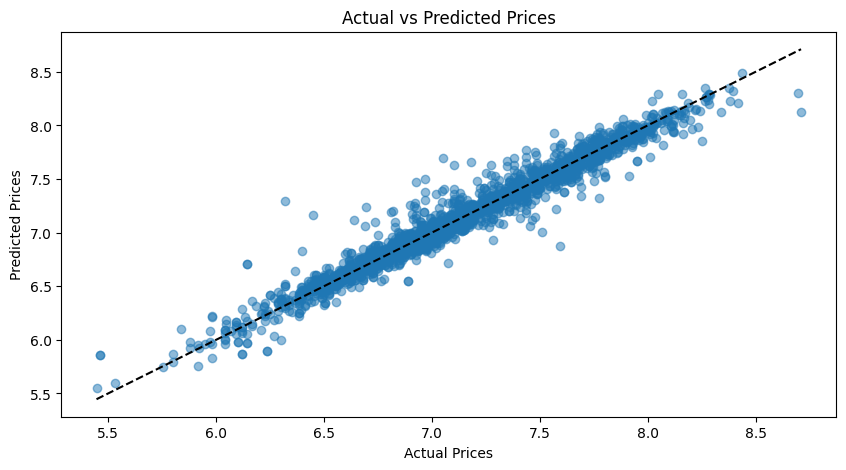

C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


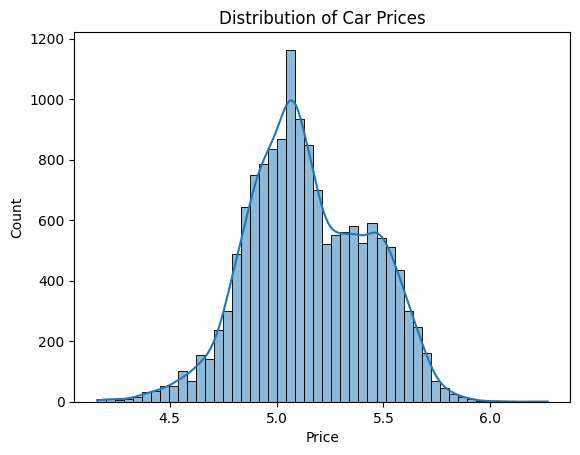

In [9]:
# Visualizations
plt.figure(figsize=(10, 5))
plt.scatter(y_test_original, y_test_pred_original, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'k--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

sns.histplot(gb_dataset['Price'], bins=50, kde=True)
plt.title("Distribution of Car Prices")
plt.show()


In [10]:
print(gb_dataset.info())  # Check column names, types, and missing values
print(gb_dataset.describe())  # View statistics of numeric features



<class 'pandas.core.frame.DataFrame'>
Index: 14940 entries, 0 to 15674
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Kilometers_Driven         14940 non-null  int64  
 1   Transmission              14940 non-null  int64  
 2   Owner_Type                14940 non-null  int64  
 3   Engine                    14940 non-null  int64  
 4   Power                     14940 non-null  float64
 5   Price                     14940 non-null  float64
 6   Fuel_Type_CNG             14940 non-null  bool   
 7   Fuel_Type_Diesel          14940 non-null  bool   
 8   Fuel_Type_E85 Flex Fuel   14940 non-null  bool   
 9   Fuel_Type_Electric        14940 non-null  bool   
 10  Fuel_Type_Gasoline        14940 non-null  bool   
 11  Fuel_Type_Hybrid          14940 non-null  bool   
 12  Fuel_Type_LPG             14940 non-null  bool   
 13  Fuel_Type_Petrol          14940 non-null  bool   
 14  Fuel_Type_P

In [11]:
print("Missing values in dataset:\n", gb_dataset.isnull().sum())  # Check for NaNs
print("Unique Transmission values:", gb_dataset['Transmission'].unique())
print("Unique Owner Type values:", gb_dataset['Owner_Type'].unique())
print("Unique Fuel Types:", [col for col in gb_dataset.columns if 'Fuel_Type' in col])
print("Unique Brand Encodings:", [col for col in gb_dataset.columns if 'brand_' in col])


Missing values in dataset:
 Kilometers_Driven           0
Transmission                0
Owner_Type                  0
Engine                      0
Power                       0
Price                       0
Fuel_Type_CNG               0
Fuel_Type_Diesel            0
Fuel_Type_E85 Flex Fuel     0
Fuel_Type_Electric          0
Fuel_Type_Gasoline          0
Fuel_Type_Hybrid            0
Fuel_Type_LPG               0
Fuel_Type_Petrol            0
Fuel_Type_Plug-In Hybrid    0
brand_Audi                  0
brand_BMW                   0
brand_Cadillac              0
brand_Chevrolet             0
brand_Ford                  0
brand_GMC                   0
brand_Honda                 0
brand_Hyundai               0
brand_Jaguar                0
brand_Jeep                  0
brand_Land Rover            0
brand_Lexus                 0
brand_Mahindra              0
brand_Maruti                0
brand_Mercedes-Benz         0
brand_Nissan                0
brand_Other                 0
brand_Porsch

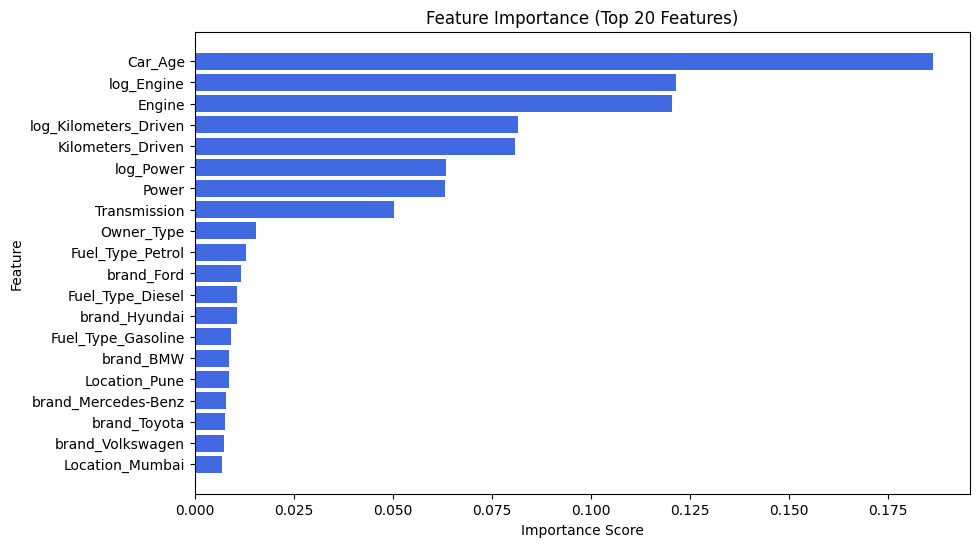

                  Feature  Importance
52                Car_Age    0.186391
50             log_Engine    0.121609
3                  Engine    0.120667
49  log_Kilometers_Driven    0.081646
0       Kilometers_Driven    0.080898
51              log_Power    0.063384
4                   Power    0.063155
1            Transmission    0.050338
2              Owner_Type    0.015638
12       Fuel_Type_Petrol    0.013042
18             brand_Ford    0.011851
6        Fuel_Type_Diesel    0.010676
21          brand_Hyundai    0.010672
9      Fuel_Type_Gasoline    0.009308
15              brand_BMW    0.008762
47          Location_Pune    0.008702
28    brand_Mercedes-Benz    0.008068
35           brand_Toyota    0.007622
36       brand_Volkswagen    0.007336
46        Location_Mumbai    0.006858


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances from all trees and average them
feature_importance = np.mean([tree.feature_importances_ for tree in final_gb.models], axis=0)

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance (Top 20)
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:20], importance_df["Importance"][:20], color="royalblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Top 20 Features)")
plt.gca().invert_yaxis()  # Flip the chart for better readability
plt.show()

# Display top features
print(importance_df.head(20))


In [23]:
#created w/gpt without real prices, we are predicting the prices
# Load the new dataset
new_s_data = pd.read_csv("Synthetic_new_s_data.csv")

# Display the first few rows
print(new_s_data.head())


   Kilometers_Driven  Transmission  Owner_Type  Engine       Power  Car_Age  \
0             126958             0           0    2516  164.461607       13   
1             136932             0           3    1993  283.657685       19   
2             108694             1           1    1155  332.746080       21   
3             124879             0           1     990  316.799797       19   
4             115268             2           4    3269  329.234777       10   

   Luxury  Fuel_Type_CNG  Fuel_Type_Diesel  Fuel_Type_Electric  ...  \
0       0              0                 0                   0  ...   
1       0              1                 0                   0  ...   
2       0              0                 1                   0  ...   
3       0              0                 0                   0  ...   
4       0              0                 0                   0  ...   

   Location_Jaipur  Location_Kochi  Location_Kolkata  Location_Mumbai  \
0                0       

In [25]:
# 1. Drop 'log_Price' (it's not a feature used in prediction)
if 'log_Price' in new_s_data.columns:
    new_s_data.drop(columns=['log_Price'], inplace=True)

# 2. Apply necessary log transformations
new_s_data['log_Kilometers_Driven'] = np.log1p(new_s_data['Kilometers_Driven'])
new_s_data['log_Engine'] = np.log1p(new_s_data['Engine'].replace(0, 1))
new_s_data['log_Power'] = np.log1p(new_s_data['Power'].replace(0, 1))

# 3. Align columns with training features
expected_features = list(X_train.columns)
X_test_new = new_s_data.reindex(columns=expected_features, fill_value=0)

# 4. Predict and reverse the log transformation
y_test_new_pred = final_gb.predict(X_test_new)
y_test_new_pred_original = np.expm1(y_test_new_pred)

# 5. Attach predictions back to the original new dataset
new_s_data['Predicted_Price'] = y_test_new_pred_original

# 6. Show or export results
print(new_s_data[['Kilometers_Driven', 'Engine', 'Power', 'Car_Age', 'Predicted_Price']].head(10))

# Optional: Save predictions to CSV
new_s_data.to_csv("predicted_car_prices.csv", index=False)
print("✅ Predictions saved to 'predicted_car_prices.csv'")


   Kilometers_Driven  Engine       Power  Car_Age  Predicted_Price
0             126958    2516  164.461607       13         5.250007
1             136932    1993  283.657685       19         4.968505
2             108694    1155  332.746080       21         5.074654
3             124879     990  316.799797       19         4.890213
4             115268    3269  329.234777       10         5.479619
5              59886    1499  202.454160        3         5.469110
6             142337    2854  336.241976       14         5.219571
7              92498    2980   92.073169       26         5.342057
8             117727    1356  240.571184       19         5.097600
9             131324    1625   52.015531        5         5.069421
✅ Predictions saved to 'predicted_car_prices.csv'


In [26]:
# Sort by predicted price
sorted_data = new_s_data.sort_values(by="Predicted_Price", ascending=False)

# Top 5 most expensive predictions
print("💰 Top 5 Expensive Cars:")
print(sorted_data.head(5)[["Engine", "Power", "Car_Age", "Predicted_Price"]])

# Bottom 5 cheapest predictions
print("\n🪙 Bottom 5 Cheapest Cars:")
print(sorted_data.tail(5)[["Engine", "Power", "Car_Age", "Predicted_Price"]])


💰 Top 5 Expensive Cars:
     Engine       Power  Car_Age  Predicted_Price
73     1084  242.579290        4         5.696601
17     2929  180.638127        4         5.681055
405    2725  247.757698        2         5.672326
298    2777  362.229641        3         5.660277
138    2509  236.535225        6         5.633241

🪙 Bottom 5 Cheapest Cars:
     Engine       Power  Car_Age  Predicted_Price
496    1288   58.467117       16         4.661059
447    1107   51.126392       19         4.659763
119    1369   86.438377       25         4.651550
248    1258  156.146302       27         4.623398
323    1554   75.229518       28         4.500409


C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


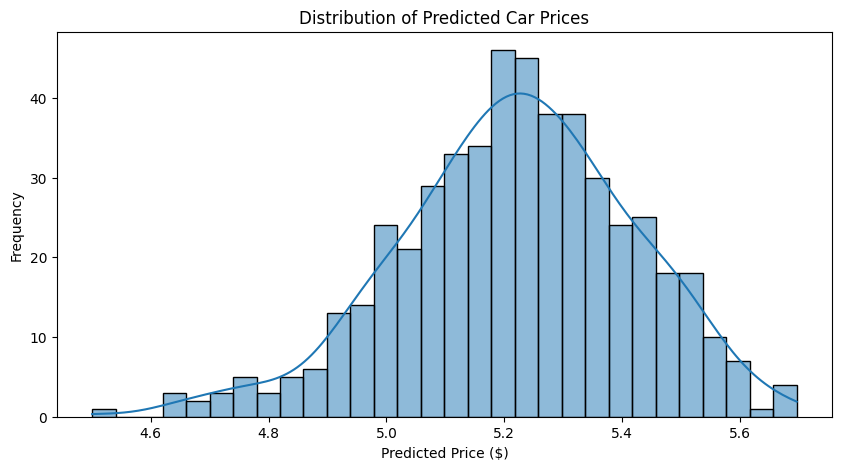

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(new_s_data["Predicted_Price"], bins=30, kde=True)
plt.title("Distribution of Predicted Car Prices")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Frequency")
plt.show()


C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


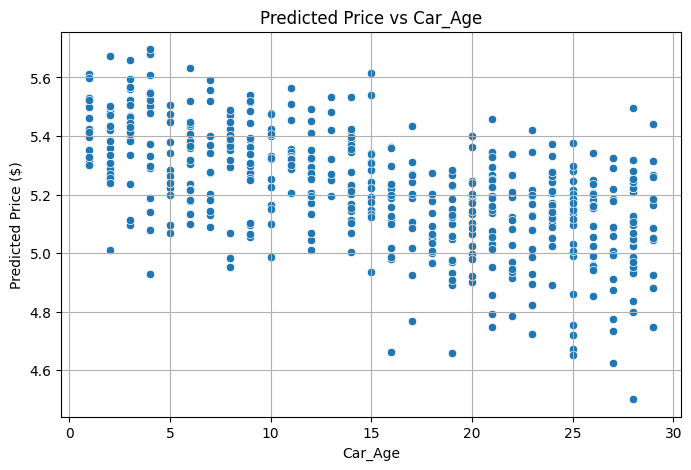

C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


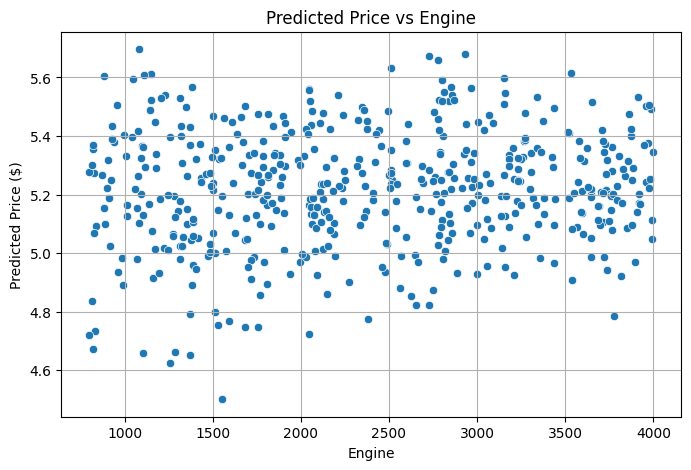

C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atlyz\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


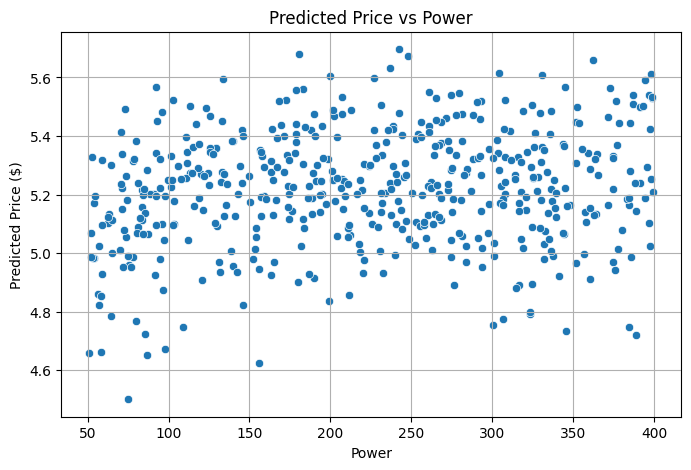

In [28]:
features_to_check = ["Car_Age", "Engine", "Power"]

for feature in features_to_check:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=new_s_data[feature], y=new_s_data["Predicted_Price"])
    plt.title(f"Predicted Price vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Predicted Price ($)")
    plt.grid(True)
    plt.show()


In [29]:
# Suppose the buyer's budget is $5.1k
budget = 5.1
recommended = new_s_data[new_s_data["Predicted_Price"] <= budget]

print(f"🚗 Cars within ${budget}k:")
print(recommended[["Engine", "Power", "Car_Age", "Predicted_Price"]].sort_values(by="Predicted_Price", ascending=False))


🚗 Cars within $5.1k:
     Engine       Power  Car_Age  Predicted_Price
217     889  225.898127       24         5.099016
57     2065  263.616824       10         5.098586
260    1770   95.748632       16         5.097967
8      1356  240.571184       19         5.097600
316    2335  102.559150        9         5.096890
..      ...         ...      ...              ...
496    1288   58.467117       16         4.661059
447    1107   51.126392       19         4.659763
119    1369   86.438377       25         4.651550
248    1258  156.146302       27         4.623398
323    1554   75.229518       28         4.500409

[131 rows x 4 columns]


In [ ]:
'''
1️⃣ RMSE (Root Mean Squared Error)
📌 RMSE tells us how far off our model’s predictions are, on average.
✔ Lower RMSE = Better model performance
✔ RMSE is measured in the same unit as Price, so your model's average error is ~$6,000 when predicting car prices.
✔ The RMSE on validation/test is slightly higher than train, which is expected.

2️⃣ MAE (Mean Absolute Error)
📌 MAE measures the absolute difference between predictions and actual values.
✔ More interpretable than RMSE because it doesn’t penalize large errors as much.
✔ Your model on average makes an error of ~$3,500 in car price predictions.

3️⃣ R² Score (Coefficient of Determination)
📌 R² tells us how much of the variation in Price is explained by our model.
✔ Closer to 1 = Better model fit.
✔ R² = 0.7516 means ~75% of price variation is explained by our model.

💡 Interpretation:

A high R² (~0.75) means our model is performing well, but it still has room for improvement.
RMSE of ~6000 means our model is not perfect but gives reasonable predictions.
'''

In [ ]:
'''
📌 Lower RMSE → The model is making more accurate price predictions.
📌 Lower MAE → On average, the model is off by only ~$2,966.
📌 Higher R² → The model explains ~81% of the variation in car prices.
'''

In [ ]:
⚠️ Minor Observations:

Luxury Car Flag (All 0s)
→ Luxury column is all zeros, meaning no cars were classified as luxury using the Price > 100,000 rule.
➡️ Fix: Either lower the threshold or check if the transformed price scale affects this.